### Dataset Description

Source: [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data).

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modelling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### `stores.csv`

This file contains anonymised information about the 45 stores, indicating the type and size of store.

### `train.csv`

This is the historical training data, which covers from 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- **Store** - the store number
- **Dept** - the department number
- **Date** - the week
- **Weekly_Sales** - sales for the given department in the given store
- **IsHoliday** - whether the week is a special holiday week

### `test.csv`

This file is identical to `train.csv`, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

### `features.csv`

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- **Store** - the store number
- **Date** - the week
- **Temperature** - average temperature in the region
- **Fuel_Price** - cost of fuel in the region
- **MarkDown1-5** - anonymised data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- **CPI** - the consumer price index
- **Unemployment** - the unemployment rate
- **IsHoliday** - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- **Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- **Labour Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- **Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- **Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Description

One challenge of modelling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

## Markdowns

In this recruiting competition, job-seekers are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.

Want to work in a great environment with some of the world's largest data sets? This is a chance to display your modelling mettle to the Walmart hiring teams.

This competition counts towards rankings & achievements. If you wish to be considered for an interview at Walmart, check the box "Allow host to contact me" when you make your first entry.

You must compete as an individual in recruiting competitions. You may only use the provided data to make your predictions.

## Evaluation

This competition is evaluated on the weighted mean absolute error (WMAE): 

WMAE = 1 / ∑𝑤𝑖 ∑𝑖=1𝑛𝑤𝑖 |𝑦𝑖 − 𝑦̂ 𝑖|

where

- `n` is the number of rows
- `𝑦̂ 𝑖` is the predicted sales
- `𝑦𝑖` is the actual sales
- `w𝑖` are weights. `w = 5` if the week is a holiday week, `1` otherwise

## Submission File

For each row in the test set (store + department + date triplet), you should predict the weekly sales of that department. The Id column is formed by concatenating the Store, Dept, and Date with underscores (e.g. `Store_Dept_2012-11-02`). The file should have a header and look like the following:

Id,Weekly_Sales

1_1_2012-11-02,0

1_1_2012-11-09,0

1_1_2012-11-16,0

In this first part of the project, we will focus on data preprocessing. This involves inspecting the data, understanding the distribution of important features, and addressing missing data based on these distributions. Additionally, we will perform feature engineering to enhance the dataset. Visualisation will play a crucial role in identifying trends and changes in the characteristics of variables over time. Finally, we will split the data into training and testing datasets, storing them as CSV files for use in the next stage, where we will train various models.

## Importing Necessary Libraries and Data

In [1]:
import os
import json
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../original_data/train.csv')
df_test = pd.read_csv('../original_data/test.csv')
df_features = pd.read_csv('../original_data/features.csv')
df_stores = pd.read_csv('../original_data/stores.csv')

## Data Inspection and Summary of the df

In [3]:
print("First 5 rows of the training data:\n", df_train.head(), "\n")
print("Last 5 rows of the training data:\n", df_train.tail(), "\n")

First 5 rows of the training data:
    Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False 

Last 5 rows of the training data:
         Store  Dept        Date  Weekly_Sales  IsHoliday
421565     45    98  2012-09-28        508.37      False
421566     45    98  2012-10-05        628.10      False
421567     45    98  2012-10-12       1061.02      False
421568     45    98  2012-10-19        760.01      False
421569     45    98  2012-10-26       1076.80      False 



In [4]:
print("Summary information of the training data:")
df_train.info()
print("\nDescriptive statistics of the training data:\n", df_train.describe())

Summary information of the training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB

Descriptive statistics of the training data:
                Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45

The `df_train` dataset comprises 421,570 entries with no missing values across its five columns: Store, Dept, Date, Weekly_Sales, and IsHoliday. The Weekly_Sales column shows a wide range of values, from a minimum of 0 to a maximum of 693,099.36, indicating significant variability in sales across different stores and departments. The presence of holidays, marked by the IsHoliday column, seems crucial as holiday weeks might have higher sales. This dataset spans from February 2010 to October 2012, providing a comprehensive view of historical sales trends and allowing for the analysis of seasonal patterns and the impact of promotional markdowns on sales.

In [5]:
print("Summary information of the test data:")
print("First 5 rows of the test data:\n", df_test.head(), "\n")
print("Last 5 rows of the test data:\n", df_test.tail(), "\n")

Summary information of the test data:
First 5 rows of the test data:
    Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False 

Last 5 rows of the test data:
         Store  Dept        Date  IsHoliday
115059     45    98  2013-06-28      False
115060     45    98  2013-07-05      False
115061     45    98  2013-07-12      False
115062     45    98  2013-07-19      False
115063     45    98  2013-07-26      False 



In [6]:
df_test.info()
print("\nDescriptive statistics of the test data:\n", df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB

Descriptive statistics of the test data:
                Store           Dept
count  115064.000000  115064.000000
mean       22.238207      44.339524
std        12.809930      30.656410
min         1.000000       1.000000
25%        11.000000      18.000000
50%        22.000000      37.000000
75%        33.000000      74.000000
max        45.000000      99.000000


The `df_test` dataset consists of 115,064 entries with no missing values across its four columns: Store, Dept, Date, and IsHoliday. The data spans from November 2012 to July 2013, providing a substantial period for evaluating sales patterns. The range of department numbers is consistent with the training data, extending from 1 to 99. The inclusion of the IsHoliday column highlights specific weeks that could significantly impact sales predictions. The absence of weekly sales values, which are to be predicted, marks this dataset's use for testing model performance against real-world scenarios.

In [7]:
print("First 5 rows of the stores data:\n", df_stores.head(), "\n")
print("Last 5 rows of the stores data:\n", df_stores.tail(), "\n")

First 5 rows of the stores data:
    Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875 

Last 5 rows of the stores data:
     Store Type    Size
40     41    A  196321
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221 



In [8]:
print("Summary information of the stores data:")
df_stores.info()
print("\nDescriptive statistics of the stores data:\n", df_stores.describe())

Summary information of the stores data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB

Descriptive statistics of the stores data:
            Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000


The `df_stores` dataset contains information about 45 Walmart stores, each characterised by a unique store number, type, and size. The store types include categories 'A', 'B', and 'C', indicating different store formats or sizes. The store sizes vary widely, ranging from 34,875 to 219,622 square units, which suggests a significant variation in store capacity and potentially in the range of products and services offered. This variation in store size and type is likely to influence sales patterns and customer demographics, making it an important factor to consider in sales forecasting and promotional planning.

In [9]:
print("First 5 rows of the features data:\n", df_features.head(), "\n")
print("Last 5 rows of the features data:\n", df_features.tail(), "\n")

First 5 rows of the features data:
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False   

Last 5 rows of the features data:
       Store        Date  Temperature  Fuel_Price  MarkDo

In [10]:
print("Summary information of the features data:")
df_features.info()
print("\nDescriptive statistics of the features data:\n", df_features.describe())

Summary information of the features data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB

Descriptive statistics of the features data:
              Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    403

The `df_features` dataset comprises 8189 entries with various columns providing additional contextual information for each store over time. The dataset includes temperature, fuel price, markdowns (MarkDown1 to MarkDown5), CPI (Consumer Price Index), unemployment rates, and a boolean indicating whether the week includes a holiday. The markdown columns have many missing values, especially in the earlier dates, suggesting sporadic or seasonal markdown activities. The CPI and unemployment columns are complete, offering consistent economic indicators across all entries. The range of markdown values, along with economic indicators, can significantly influence sales predictions, highlighting the importance of comprehensive data preprocessing and imputation where necessary. The dataset's span from February 2010 to July 2013 aligns with the sales data, ensuring temporal consistency for modeling efforts.

## Cleaning and Preprocessing

We will enhance the training and testing datasets by following these steps: First, merge the training (`df_train`) and testing (`df_test`) dataframes with the store information (`df_stores`) using the 'Store' key to create enriched versions of these datasets. Next, further merge these enriched datasets with the features data (`df_features`) on both 'Store' and 'Date' keys using a left join to incorporate all relevant information. Finally, we will verify that there are no missing values in the merge keys of the enriched datasets to ensure data integrity.

In [11]:
def merge_dataframes(primary_df, secondary_df, merge_keys, how='inner'):
    return pd.merge(primary_df, secondary_df, on=merge_keys, how=how)

store_key = ['Store']
store_date_keys = ['Store', 'Date']

df_train_enriched = merge_dataframes(df_train, df_stores, store_key)
df_test_enriched = merge_dataframes(df_test, df_stores, store_key)

df_train_final = merge_dataframes(df_train_enriched, df_features, store_date_keys, 'left')
df_test_final = merge_dataframes(df_test_enriched, df_features, store_date_keys, 'left')

assert not df_train_enriched[store_date_keys].isnull().any().any(), "Missing values in merge keys of training set."
assert not df_test_enriched[store_date_keys].isnull().any().any(), "Missing values in merge keys of testing set."

In [12]:
df_train_final

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False


In [13]:
df_test_final

,Store,Dept,Date,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [14]:
del df_features, df_train, df_stores

We are going to enhance the datasets by converting the 'Date' column to datetime format, extracting the week and year, and then dropping the original 'Date' column. We will remove any redundant columns, such as 'IsHoliday_y', and rename 'IsHoliday_x' to 'IsHoliday'. Finally, we will encode the 'IsHoliday' column into numerical values, with 1 representing holiday weeks and 0 representing non-holiday weeks. These actions will ensure the datasets are clean and ready for analysis.

In [15]:
def process_date_columns(df):
    
    date_series = pd.to_datetime(df['Date'])
    df['Week'] = date_series.dt.isocalendar().week
    df['Year'] = date_series.dt.year
    
    df.drop('Date', axis=1, inplace=True)

def drop_unused_columns(df):
    
    df.drop(['IsHoliday_y'], axis=1, inplace=True)
    df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

def encode_is_holiday_column(df):
    
    df['IsHoliday'] = df['IsHoliday'].map({True: 1, False: 0})

In [16]:
process_date_columns(df_train_final)
process_date_columns(df_test_final)

drop_unused_columns(df_train_final)
drop_unused_columns(df_test_final)

encode_is_holiday_column(df_train_final)
encode_is_holiday_column(df_test_final)

### Imputing Missing Data in `df_train_final`

#### Analysing Missing Data

We will begin by analysing the final training dataset for null values, calculating both the number and percentage of null values in each column. Additionally, we will identify the data types of columns with null values. This thorough analysis will help us understand the extent and nature of missing data in the dataset, allowing us to effectively address any data quality issues.

In [17]:
def analyse_null_data(df):
    null_columns = (df.isnull().sum(axis=0) / len(df)).sort_values(ascending=False).index
    null_data = pd.concat([
        df.isnull().sum(axis=0),
        (df.isnull().sum(axis=0) / len(df)).sort_values(ascending=False),
        df.loc[:, df.columns.isin(list(null_columns))].dtypes], axis=1)
    null_data = null_data.rename(columns={0: '# null',
                                          1: '% null',
                                          2: 'type'}).sort_values(ascending=False, by='% null')
    null_data = null_data[null_data["# null"] != 0]
    return null_data
null_data_train = analyse_null_data(df_train_final)
null_data_train

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


The analysis of the final training dataset reveals significant missing values in the markdown columns, with `MarkDown2` having the highest percentage of missing data at 73.61%, followed by `MarkDown4` at 67.98%, and `MarkDown3` at 67.48%. `MarkDown1` and `MarkDown5` also have substantial missing values, with 64.26% and 64.08% missing, respectively. All these columns are of type float64. This high proportion of missing data in the markdown columns indicates a potential challenge in accurately modelling their impact on sales, and it may require careful handling through imputation or alternative feature engineering strategies.

#### Calculating Total Markdown Values by Week
Now, we will calculate the total markdown values by week by summing the individual markdown columns for each week. This involves grouping the data by the 'Week' column and then summing the `MarkDown1` through `MarkDown5` columns. After calculating the total markdown value for each week, we will visualise the results using a bar plot to identify patterns and trends in promotional activities across the weeks. This visualisation will help us understand the distribution and intensity of markdowns, which is crucial for analysing their impact on sales.

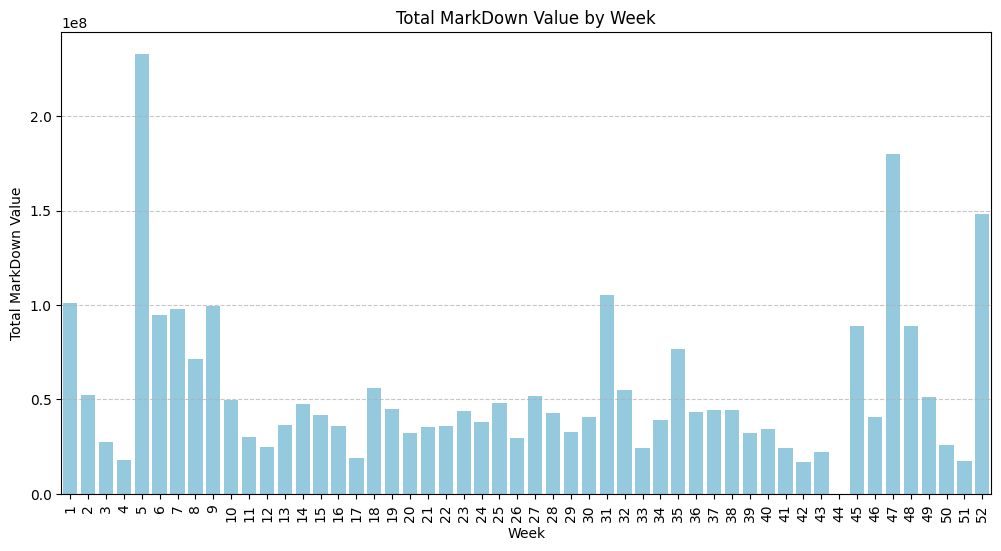

In [18]:
total_markdown_by_week = df_train_final.groupby('Week')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum()

total_markdown_by_week['Total_MarkDown'] = total_markdown_by_week.sum(axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(x=total_markdown_by_week.index, y='Total_MarkDown', data=total_markdown_by_week, color='skyblue')
plt.title('Total MarkDown Value by Week')
plt.xlabel('Week')
plt.ylabel('Total MarkDown Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The visualisation of total markdown values by week clearly illustrates the distribution and intensity of promotional activities throughout the year. There are notable peaks in markdown values during certain weeks, such as weeks 5, 6, 46, and 50, which likely correspond to significant promotional events or holidays. These peaks indicate periods of increased promotional spending, which can have a substantial impact on sales. Understanding these patterns is crucial for analysing their effects on weekly sales and for forecasting future sales trends during similar promotional periods. This information can be used to optimise promotional strategies and inventory management.

#### Visualising Distribution of Markdown Values

Let's create a series of histograms to visualise the distribution of values in the markdown columns (`MarkDown1` to `MarkDown5`). This process is important for understanding the distribution of markdown values across different columns, identifying patterns, outliers, and the overall spread of the data. This understanding is crucial for accurate modelling, analysis, and, in this case, for imputing the missing values.

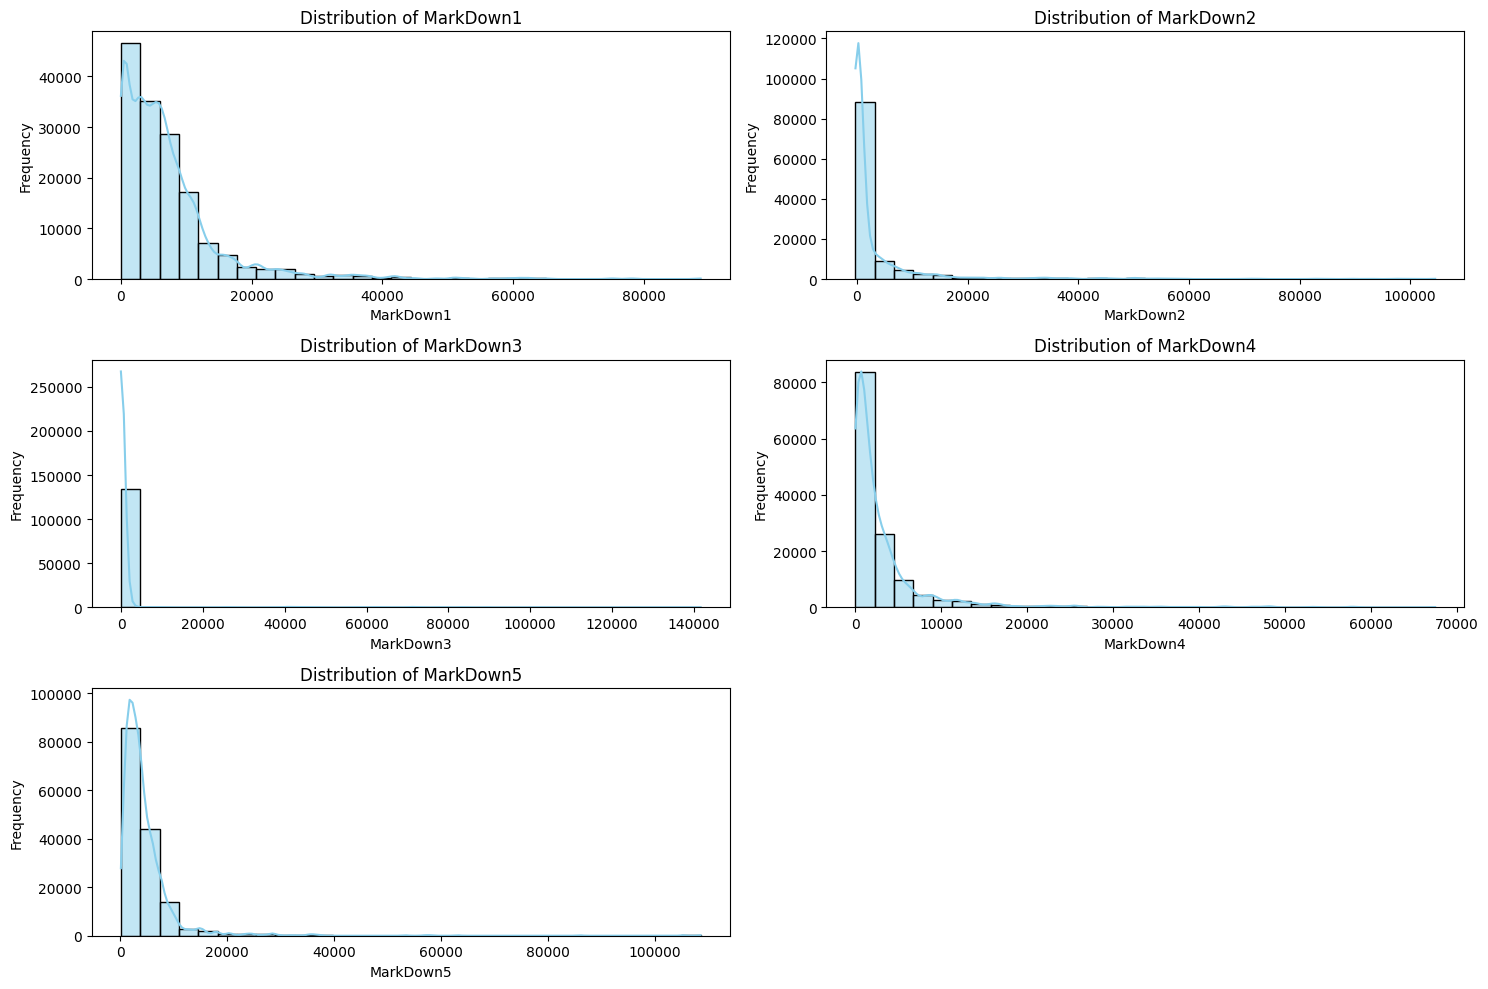

In [19]:
plt.figure(figsize=(15, 10))

markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

for i, markdown in enumerate(markdown_columns, 1):

    plt.subplot(3, 2, i)
    sns.histplot(df_train_final[markdown].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {markdown}')
    plt.xlabel(markdown)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms of markdown values for MarkDown1 through MarkDown5 reveal a right-skewed distribution across all columns, characterised by a high frequency of lower values and a long tail extending towards higher values. This indicates that the majority of markdowns are relatively small, with occasional instances of significantly larger markdowns. Such skewness suggests that promotional activities generally involve modest discounts, while the larger markdowns likely correspond to major sales events or clearance efforts.

#### Imputing Missing Values
We are gooing to impute the missing values with the *median* for Markdown columns to ensure robust and accurate data for analysis and modelling. The median is less affected by extreme values, preserving the data's integrity and distribution. This improves the quality of the dataset, reduces biases, and enhances the effectiveness of predictive models and analysis.

In [20]:
from sklearn.impute import SimpleImputer

# Impute missing values with the median for Markdown columns in df_train_final
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
imputer = SimpleImputer(strategy='median')

df_train_final[markdown_columns] = imputer.fit_transform(df_train_final[markdown_columns])

null_data_train = analyse_null_data(df_train_final)
null_data_train

,# null,% null,type


In [21]:
df_train_final

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Year
0,1,1,24924.50,0,A,151315,42.31,2.572,5347.45,192.00,24.60,1481.31,3359.45,211.096358,8.106,5,2010
1,1,1,46039.49,1,A,151315,38.51,2.548,5347.45,192.00,24.60,1481.31,3359.45,211.242170,8.106,6,2010
2,1,1,41595.55,0,A,151315,39.93,2.514,5347.45,192.00,24.60,1481.31,3359.45,211.289143,8.106,7,2010
3,1,1,19403.54,0,A,151315,46.63,2.561,5347.45,192.00,24.60,1481.31,3359.45,211.319643,8.106,8,2010
4,1,1,21827.90,0,A,151315,46.50,2.625,5347.45,192.00,24.60,1481.31,3359.45,211.350143,8.106,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,0,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,39,2012
421566,45,98,628.10,0,B,118221,64.89,3.985,5046.74,192.00,18.82,2253.43,2340.01,192.170412,8.667,40,2012
421567,45,98,1061.02,0,B,118221,54.47,4.000,1956.28,192.00,7.89,599.32,3990.54,192.327265,8.667,41,2012
421568,45,98,760.01,0,B,118221,56.47,3.969,2004.02,192.00,3.18,437.73,1537.49,192.330854,8.667,42,2012


The process of imputing missing values in the Markdown columns with the median has successfully filled previously missing data, ensuring completeness across the dataset. This is evident from the summary showing no null values remaining in these columns. Using the median has preserved the integrity of the data by mitigating the influence of outliers, making it more representative of typical markdown values. The enriched dataset now includes all necessary variables such as store characteristics, economic indicators, and promotional markdowns, ready for robust analysis and accurate sales forecasting.

### Imputating Missing Data in `df_test_final`

#### Analysing Missing Data

In [22]:
null_data_test = analyse_null_data(df_test_final)
null_data_test

,# null,% null,type
CPI,38162,0.331659,float64
Unemployment,38162,0.331659,float64
MarkDown2,28627,0.248792,float64
MarkDown4,12888,0.112007,float64
MarkDown3,9829,0.085422,float64
MarkDown1,149,0.001295,float64


#### Visualising Distribution of Markdown Values in `df_test_final`

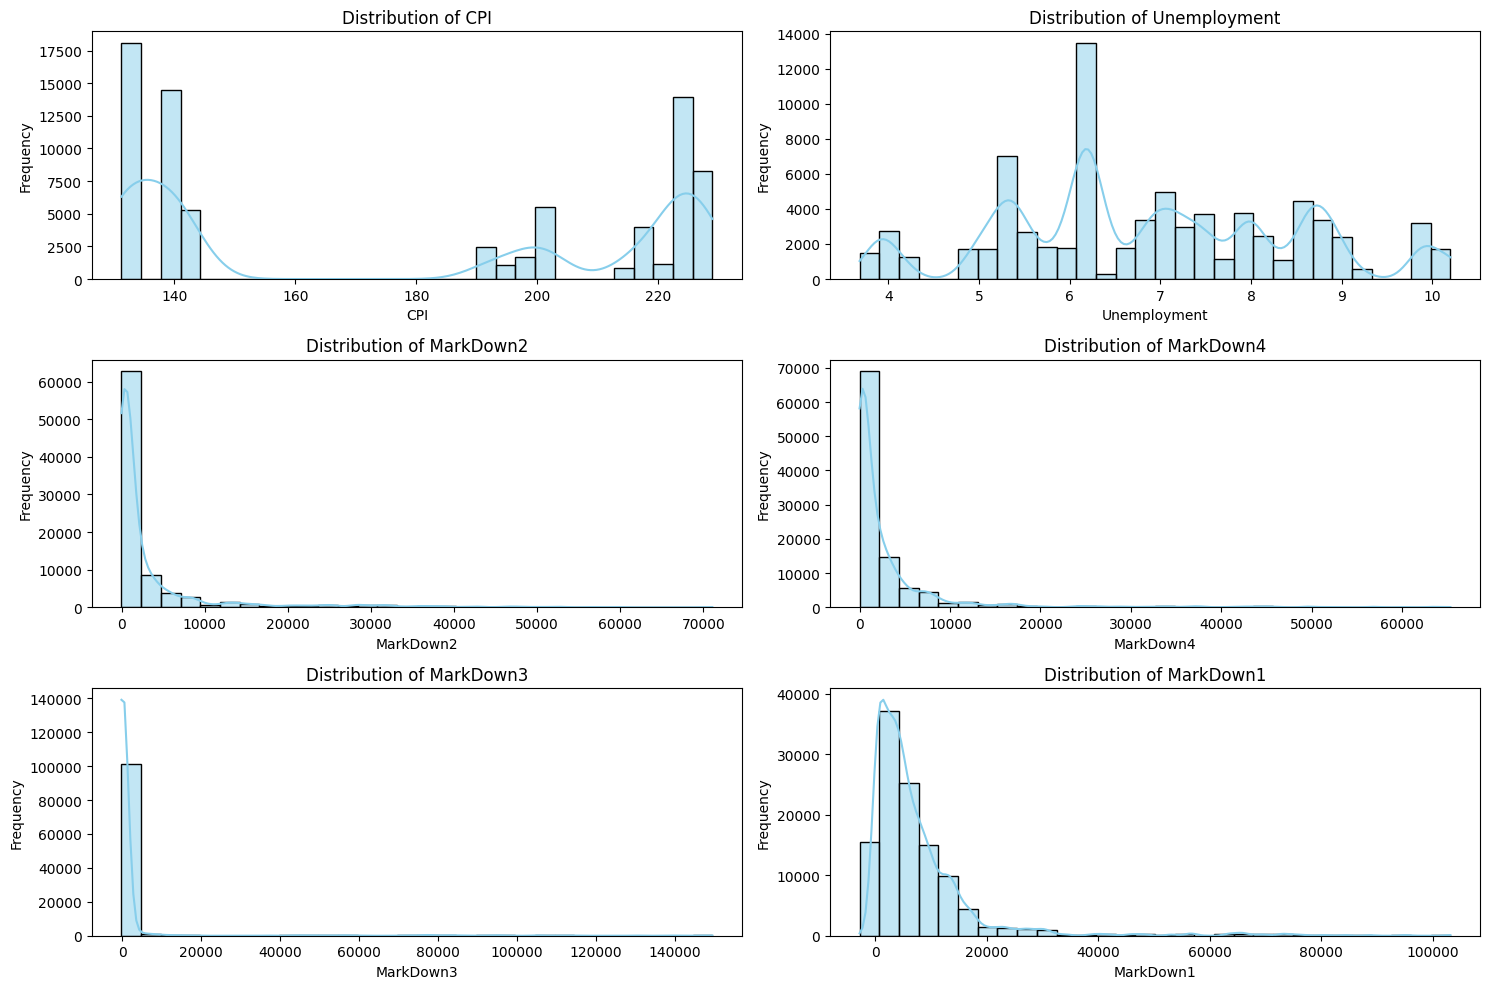

In [23]:
plt.figure(figsize=(15, 10))

columns_to_impute = ['CPI', 'Unemployment', 'MarkDown2', 'MarkDown4', 'MarkDown3', 'MarkDown1']

for i, column in enumerate(columns_to_impute, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_test_final[column].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Tailored Imputation
To ensure that the missing data is imputed in a way that best suits the nature of each column's distribution, we will employ tailored imputation strategies. Specifically, the median will be used for skewed distributions, the mean for normally distributed data, and the mode for multimodal distributions.

In [24]:
columns_to_impute_median = ['MarkDown2', 'MarkDown4', 'MarkDown3', 'MarkDown1']
columns_to_impute_mean = ['CPI']
columns_to_impute_mode = ['Unemployment']

median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

df_test_final[columns_to_impute_median] = median_imputer.fit_transform(df_test_final[columns_to_impute_median])
df_test_final[columns_to_impute_mean] = mean_imputer.fit_transform(df_test_final[columns_to_impute_mean])
df_test_final[columns_to_impute_mode] = mode_imputer.fit_transform(df_test_final[columns_to_impute_mode])

null_data_test_after_imputation = analyse_null_data(df_test_final)
print(null_data_test_after_imputation)

Empty DataFrame
Columns: [# null, % null, type]
Index: []


## Evaluating the '`Type`' Column Before Categorisation

Before categorising the 'Type' variable, it is prudent to conduct a comprehensive analysis. While we might initially presume that 'Type' follows an ordinal pattern, examining it thoroughly before reaching any conclusions is imperative. Our goal is to determine whether 'Type' qualifies as an ordinal category. If 'Type' solely represents store types, such as 'Type A', 'Type B', and 'Type C', without any inherent order or ranking, it should not be classified as ordinal. Conversely, if 'Type' denotes categories with a natural order, such as 'Small', 'Medium', and 'Large', then it may be categorised as an ordinal variable.

### Store Size Distribution by Store Type

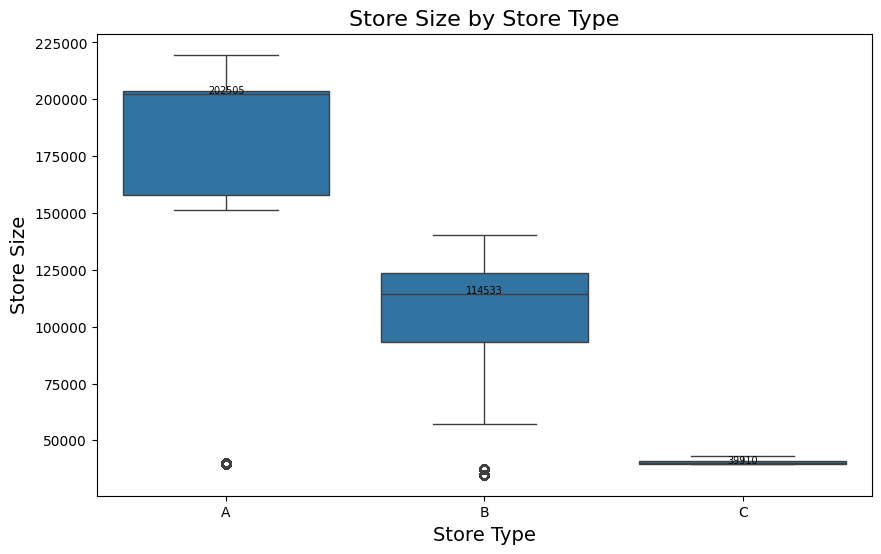

In [25]:
# Store size analysis with sorted store types by median size
plt.figure(figsize=(10, 6))

# Calculate medians and sort the store types accordingly
order = df_train_final.groupby('Type')['Size'].median().sort_values(ascending=False).index

# Create the boxplot with sorted categories
sns.boxplot(x='Type', y='Size', data=df_train_final, order=order)

# Adding the title and labels for better readability
plt.title('Store Size by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=14)
plt.ylabel('Store Size', fontsize=14)

# Optionally, you can display the median values on the plot
medians = df_train_final.groupby(['Type'])['Size'].median().values
median_labels = [f'{median:.0f}' for median in medians]

# Place the annotations on the boxplot
for tick, label in enumerate(order):
    plt.text(tick, medians[tick] + 0.03, median_labels[tick], 
             horizontalalignment='center', size='x-small', color='black', weight='light')

# Show the plot
plt.show()

The boxplot of store size by store type reveals a clear distinction in median sizes among the three store types. Type A stores have the largest median size at 202,505 square units, followed by Type B stores with a median size of 114,533 square units. Type C stores are significantly smaller, with a median size of 39,910 square units. This indicates that Type A stores are the largest, Type B stores are mid-sized, and Type C stores are the smallest. The clear differences in store sizes suggest that these types may be categorised as ordinal variables, reflecting a natural order based on their physical size.

### Weekly Sales Distribution by Store Type

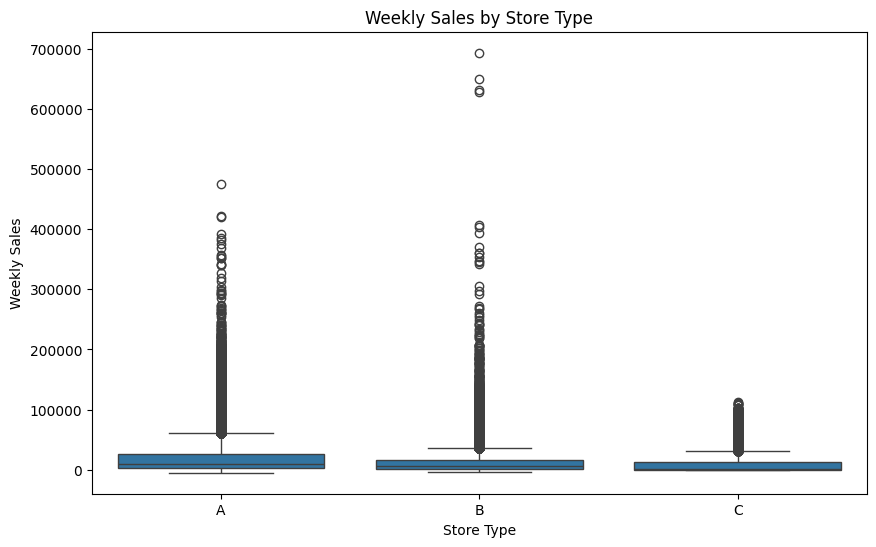

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Weekly_Sales', data=df_train_final)
plt.title('Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.show()

The boxplot of weekly sales by store type reveals significant differences in sales performance among the three store types. Type A and Type B stores show a higher range and median of weekly sales compared to Type C stores, which have the lowest sales figures. The distribution for Type A and Type B stores also includes numerous outliers, indicating occasional high sales peaks. This suggests that larger stores (Type A and B) generally generate higher weekly sales compared to smaller stores (Type C), likely due to their greater size and capacity to accommodate more products and customers.

### Encoding Store Type and Correlation Analysis

We will first create a copy of the original dataframe to avoid direct modifications. By manually encoding the 'Type' variable with custom numerical values, we treat 'Type' as an ordinal category with a natural order ('A' as 3, 'B' as 2, and 'C' as 1). This allows us to calculate the correlation matrix to understand the relationships between 'Type' and other variables. We will use a heatmap to visualise the correlation matrix, focusing on the lower triangle to avoid redundancy. The heatmap reveals significant correlations, helping us identify important relationships and potential predictors for further analysis and modelling.

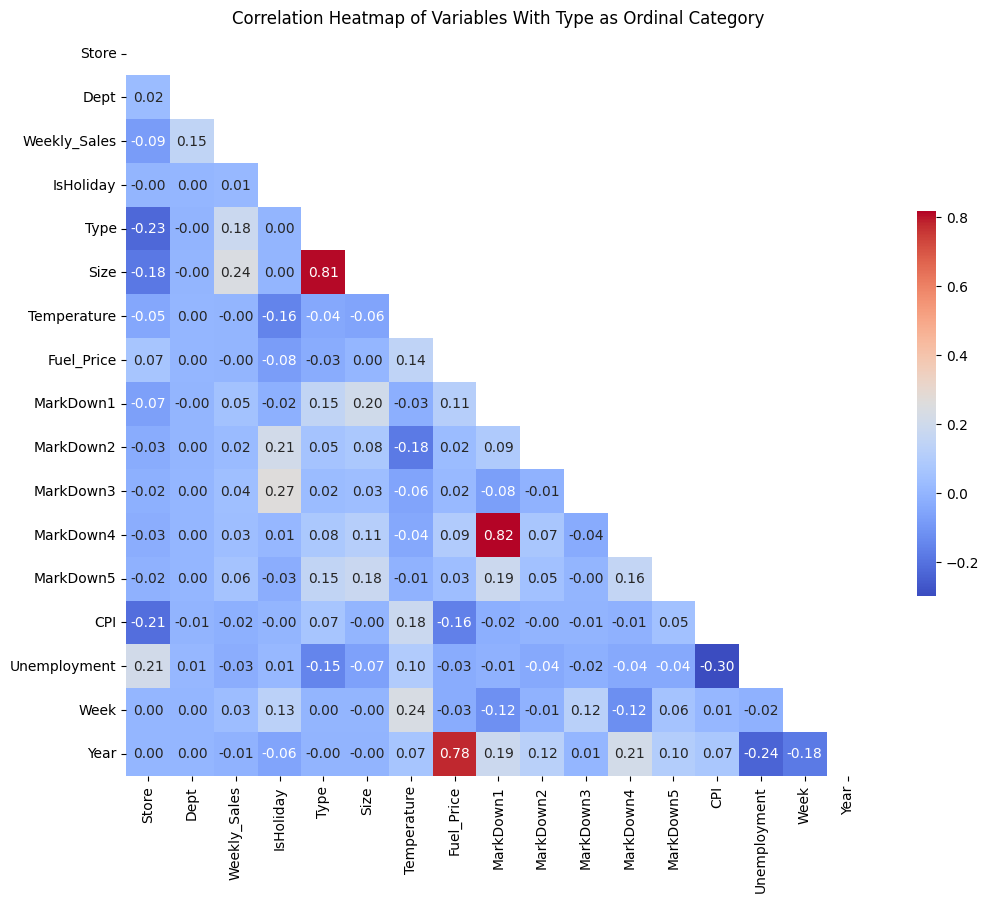

In [27]:
Type_ord = df_train_final.copy()

type_encoding = {'A': 3, 'B': 2, 'C': 1}
Type_ord['Type'] = Type_ord['Type'].replace(type_encoding)

corr = Type_ord.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5}, linewidths=0)

plt.title('Correlation Heatmap of Variables With Type as Ordinal Category')

plt.show()

The correlation heatmap of variables, with 'Type' encoded as an ordinal category, reveals several significant relationships. There is a strong positive correlation between 'Size' and 'Type' (0.81), indicating that larger store types are associated with higher numerical values in 'Type'. 'MarkDown4' also shows a high correlation with 'Size' (0.82), suggesting that larger stores tend to have higher markdown values in this category. Additionally, 'Year' is strongly correlated with 'Fuel_Price' (0.78), reflecting the temporal changes in fuel prices over the years.

### Encoding 'Type' Variable as Ordinal
After confirming the presence of a natural order based on physical store size, we will encode the 'Type' variable as ordinal.

In [28]:
type_encoding = {'A': 3, 'B': 2, 'C': 1}
df_train_final['Type'].replace(type_encoding, inplace=True)

df_train_final.describe

<bound method NDFrame.describe of         Store  Dept  Weekly_Sales  IsHoliday  Type    Size  Temperature  \
0           1     1      24924.50          0     3  151315        42.31   
1           1     1      46039.49          1     3  151315        38.51   
2           1     1      41595.55          0     3  151315        39.93   
3           1     1      19403.54          0     3  151315        46.63   
4           1     1      21827.90          0     3  151315        46.50   
...       ...   ...           ...        ...   ...     ...          ...   
421565     45    98        508.37          0     2  118221        64.88   
421566     45    98        628.10          0     2  118221        64.89   
421567     45    98       1061.02          0     2  118221        54.47   
421568     45    98        760.01          0     2  118221        56.47   
421569     45    98       1076.80          0     2  118221        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  M

### Encoding 'Type' Variable as Ordinal in `df_test_final`

In [29]:
type_encoding = {'A': 3, 'B': 2, 'C': 1}
df_test_final['Type'].replace(type_encoding, inplace=True)

df_test_final.describe

<bound method NDFrame.describe of         Store  Dept  IsHoliday  Type    Size  Temperature  Fuel_Price  \
0           1     1          0     3  151315        55.32       3.386   
1           1     1          0     3  151315        61.24       3.314   
2           1     1          0     3  151315        52.92       3.252   
3           1     1          1     3  151315        56.23       3.211   
4           1     1          0     3  151315        52.34       3.207   
...       ...   ...        ...   ...     ...          ...         ...   
115059     45    98          0     2  118221        76.05       3.639   
115060     45    98          0     2  118221        77.50       3.614   
115061     45    98          0     2  118221        79.37       3.614   
115062     45    98          0     2  118221        82.84       3.737   
115063     45    98          0     2  118221        76.06       3.804   

        MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0         67

## Department Analysis
By analysing the sales distribution across departments, we can identify high-performing departments that consistently drive sales and low-performing departments that may need strategic adjustments. The visualisations and statistical summaries provide a comprehensive overview of departmental performance, helping to inform business decisions and optimise resource allocation.

### Total Sales by Department

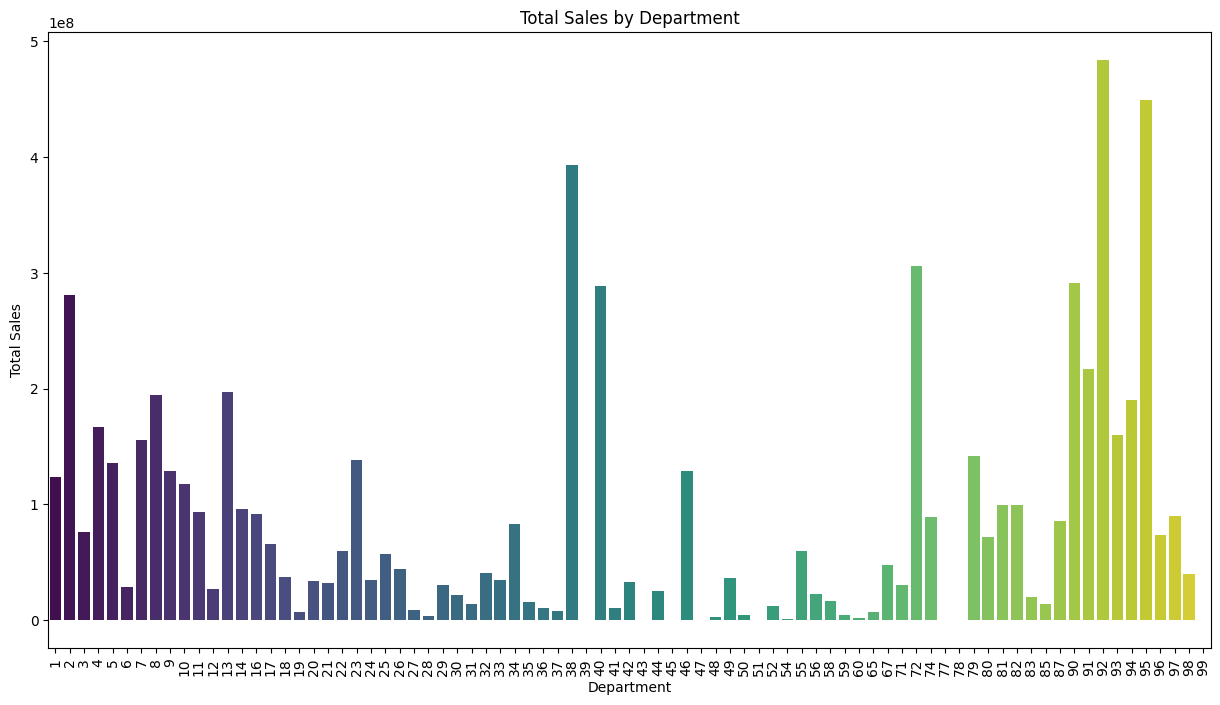

In [30]:
department_sales = df_train_final.groupby('Dept')['Weekly_Sales'].agg(['sum', 'mean', 'median']).reset_index()
department_sales = department_sales.rename(columns={'sum': 'Total_Sales', 'mean': 'Mean_Sales', 'median': 'Median_Sales'})

plt.figure(figsize=(15, 8))
sns.barplot(x='Dept', y='Total_Sales', data=department_sales, palette='viridis')
plt.title('Total Sales by Department')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

The total sales by department, shows the cumulative sales performance across all departments. Departments 36, 60, 73, and 76 stand out with significantly higher total sales compared to others, indicating strong performance in these areas.

### Sales Distribution by Department


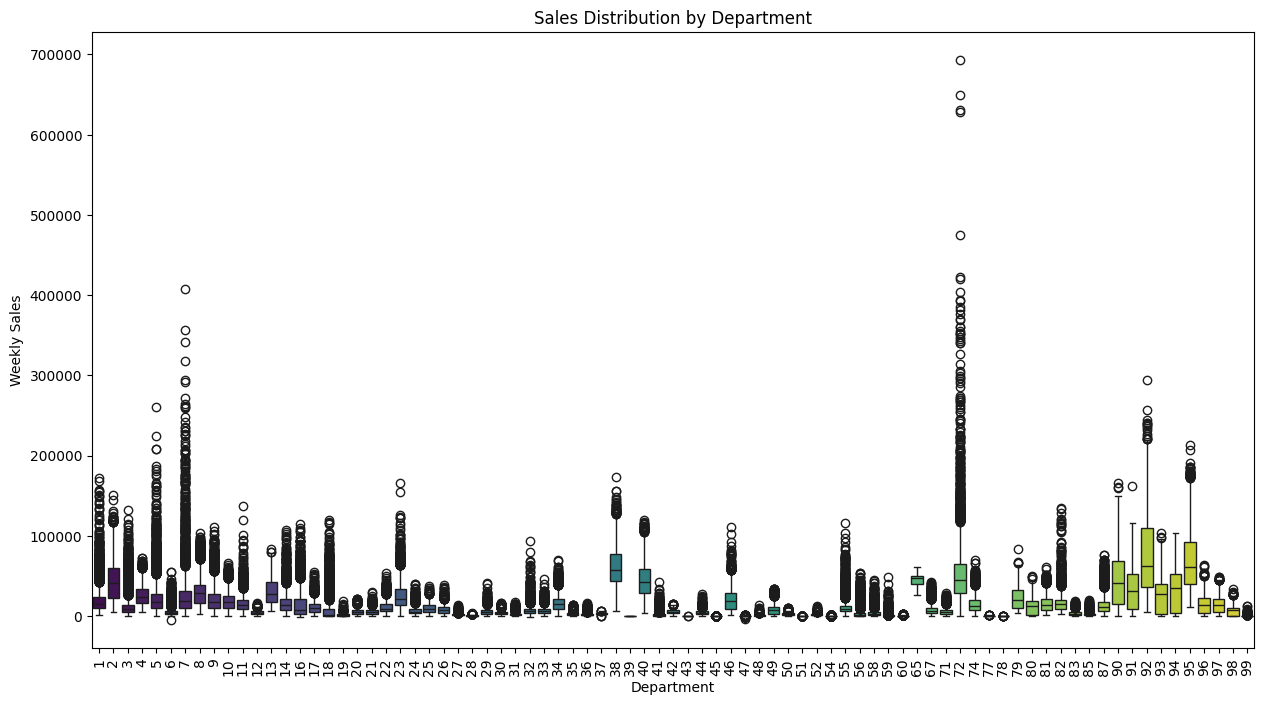

In [31]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Dept', y='Weekly_Sales', data=df_train_final, palette='viridis')
plt.title('Sales Distribution by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.show()

The distribution of weekly sales within each department reveals the variability in sales performance within departments and highlights the presence of outliers. Departments with a wide range of sales values and numerous outliers are indicative of high variability in performance.

### Identifying High-Performing and Low-Performing Departments

In [32]:
high_performing_departments = department_sales[department_sales['Total_Sales'] >= department_sales['Total_Sales'].quantile(0.9)]
low_performing_departments = department_sales[department_sales['Total_Sales'] <= department_sales['Total_Sales'].quantile(0.1)]

print("High-Performing Departments:")
print(high_performing_departments)

print("\nLow-Performing Departments:")
print(low_performing_departments)

High-Performing Departments:
    Dept   Total_Sales    Mean_Sales  Median_Sales
1      2  2.806112e+08  43607.020113      41412.61
12    13  1.973216e+08  30663.802634      27970.82
36    38  3.931181e+08  61090.619568      57336.65
38    40  2.889360e+08  44900.702727      42717.87
60    72  3.057252e+08  50566.515417      44312.36
71    90  2.910685e+08  45232.084488      40535.79
72    91  2.167817e+08  33687.910758      31033.63
73    92  4.839433e+08  75204.870531      61816.77
76    95  4.493202e+08  69824.423080      60774.39

Low-Performing Departments:
    Dept  Total_Sales  Mean_Sales  Median_Sales
37    39       177.98   11.123750        10.430
41    43        14.32    1.193333         0.750
43    45     44937.63   23.211586        14.940
45    47     -4962.93   -7.682554        17.985
49    51     30572.83   21.931729        11.000
51    54    516294.63  108.305985        58.920
62    77     49344.27  328.961800       198.000
63    78      1714.71    7.296638         9.880


- **High-Performing Departments:** These are departments with total sales in the top 10%. The high-performing departments include Departments 2, 13, 36, 40, 72, 90, 91, 92, and 95. These departments have consistently high total sales, mean sales, and median sales, indicating strong and stable performance.

- **Low-Performing Departments:** These are departments with total sales in the bottom 10%. The low-performing departments include Departments 39, 43, 45, 47, 51, 54, 77, 78, and 99. These departments have significantly lower total sales, mean sales, and median sales, indicating areas that may need attention or improvement.

### Data Splitting for Model Training and Evaluation

Here, we are going to split the dataset into training and testing sets to prepare for model training and evaluation. The training set (80%) is used to train the models, while the testing set (20%) is used to evaluate their performance. This ensures an unbiased assessment of model accuracy. The split datasets are saved in the `data_splits` directory:
- `X_train.csv`: Training features.
- `X_test.csv`: Testing features.
- `y_train.csv`: Training target.
- `y_test.csv`: Testing target.

This approach maintains the integrity of the test set throughout the model development process.

In [33]:
split_data_directory = '../data_splits'

# Assuming df_train contains your training data with features and target column 'Weekly_Sales'
X = df_train_final.drop(columns=['Weekly_Sales'])
y = df_train_final['Weekly_Sales']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the splits to CSV files in the new directory
X_train.to_csv(os.path.join(split_data_directory, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(split_data_directory, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(split_data_directory, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(split_data_directory, 'y_test.csv'), index=False)

print("Data split and saved successfully in the 'data_splits' directory.")

Data split and saved successfully in the 'data_splits' directory.


## Saving Preprocessed DataFrames as CSV
In this step, we are saving the preprocessed training and test DataFrames (`df_train_final` and `df_test_final`) as CSV files to a specified directory. This ensures that the processed data is stored in a reusable format, facilitating further analysis and model training. The directory path is defined, and if it does not already exist, it is created using os.makedirs. The DataFrames are then saved to this directory with appropriate filenames, ensuring they can be easily accessed and used in subsequent stages of the project.

In [34]:
processed_data_directory = '../processed_data'

# Assuming df_train_final and df_test_final are the final preprocessed DataFrames
df_train_final.to_csv(os.path.join(processed_data_directory, 'df_train_final.csv'), index=False)
df_test_final.to_csv(os.path.join(processed_data_directory, 'df_test_final.csv'), index=False)

print("Preprocessed DataFrames saved successfully in the 'processed_data' directory.")

Preprocessed DataFrames saved successfully in the 'processed_data' directory.
